# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#!pip install --upgrade pandas

## 1. Import Libraries and Read in the Data

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, fbeta_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from helper import cust_tran_summary, cust_offer, modeling_data

pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**portfolio metadata:**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [4]:
# View the offer portfolio data
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# View how many offers are in the offer data
portfolio.shape

(10, 6)

> **There are 10 different offers in the portfolio data**

**profile metadata:**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [6]:
# View the customer profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
# View how many customers are in the profile data
profile.shape

(17000, 5)

In [8]:
# Determine if there are any duplicates
profile.duplicated(subset=['id']).sum()

0

> **There are 17,000 customers in the profile data**

**transcript metadata:**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [9]:
# View the transaction data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
# View how many transations are in the transcript data
transcript.shape

(306534, 4)

> **There are 306,534 transactions (events) in the transcript file**

## 2. Explore and clean the data files
### Portfolio (offer) data:

In [11]:
# Create function to clean the portfolio data
def clean_portfolio(portfolio):
    '''
    This function cleans the portfolio data for analysis:
        creates dummy variables for the different channels
        renames the id column
        converts duration to hours
    
    INPUT:
    portfolio - dataframe containing offer ids and meta data about each offer (duration, type, etc.)
    
    OUTPUT:
    portfolio_clean - portfolio dataframe with cleaning process applied
    '''
        
    # Rename the id column to offer_id
    portfolio.rename(columns={'id':'offer_id'}, inplace=True)
    
    # Rename the offer_ids into something more understandable
    portfolio['offer_id'] = portfolio['offer_id'].replace({'4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo1',
                                                           '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo2',
                                                           'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo3', 
                                                           'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
                                                           '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
                                                           '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
                                                           '2906b810c7d4411798c6938adc9daaa5': 'discount3',
                                                           'fafdcd668e3743c1bb461111dcafc2a4': 'discount4',
                                                           '3f207df678b143eea3cee63160fa8bed': 'info1',
                                                           '5a8bc65990b245e5a138643cd4eb9837': 'info2'})
        
    # Create dummy variables for the different channels
    offer_ids = pd.get_dummies(portfolio.offer_id)
    # Create dummy variables for the different channels
    channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack(), prefix="ch_").sum(level=0)
    # Create dummy variables for the different offer types   
    offers = pd.get_dummies(portfolio.offer_type)
    
    # Merge the new dummy variables into the original dataframe
    portfolio_clean = pd.concat([portfolio, offer_ids, channels, offers], axis =1, sort = False)
    
    #Update the time value to be hours to coincide with the transaction data
    #portfolio_clean['duration'] = portfolio_clean['duration']*24
    
    # Drop the original channels column
    portfolio_clean.drop('channels', axis = 1, inplace = True)

    return portfolio_clean

In [12]:
# Apply the cleaning function and view the data
portfolio_clean = clean_portfolio(portfolio)
portfolio_clean.head(10)

,difficulty,duration,offer_id,offer_type,reward,bogo1,bogo2,bogo3,bogo4,discount1,discount2,discount3,discount4,info1,info2,ch__email,ch__mobile,ch__social,ch__web,bogo,discount,informational
0,10,7,bogo3,bogo,10,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0
1,10,5,bogo1,bogo,10,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0
2,0,4,info1,informational,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1
3,5,7,bogo2,bogo,5,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0
4,20,10,discount1,discount,5,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
5,7,7,discount2,discount,3,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,1,0
6,10,10,discount4,discount,2,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0
7,0,3,info2,informational,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1
8,5,5,bogo4,bogo,5,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0
9,10,7,discount3,discount,2,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0


### Profile (customer) data:

In [13]:
# View the distribution of age and income
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [14]:
#View the distribtion of the highest ages
profile.age.value_counts().sort_index(ascending=False).head()

118    2175
101       5
100      12
99        5
98        5
Name: age, dtype: int64

> **It seems that the customers have been assigned the value 118 for age if there age was missing**

In [15]:
#Check for missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

> **It appears that 2175 individuals did not complete the demographics on their profile. I could replace the missing values with the mean and mode of the columns, but I decided to remove these individuals instead as it is only a small percentage of the data.**

In [16]:
# Create function to clean the profile data
def clean_profile(profile):
    '''
    This function cleans the profile data for analysis:
        rename columns
        rename the values of gender
        create new columns for upcoming analysis
        remove individuals with missing demographic data
    
    INPUT:
    profile - dataframe containing demographic data for each customer
    
    OUTPUT:
    profile_clean - profile dataframe with cleaning process applied
    '''
        
    # Rename the id column to customer_id
    profile.rename(columns={'id':'customer_id'}, inplace=True)
    
    # Create dummy variables for the different genders
    genders = pd.get_dummies(profile.gender, prefix="gender")
    # Rename the gender columns
    genders.rename(columns={'gender_F':'female', 'gender_M':'male', 'gender_O':'other_gender'}, inplace=True)
    
    # Merge the new dummy variables into the original dataframe
    profile_clean = pd.concat([profile, genders], axis =1, sort = False)
    
    # Convert the became_member_on column from an integer to a date field
    profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')
    
    #Calculate the member_month
    profile_clean['member_month'] = pd.DatetimeIndex(profile_clean['became_member_on']).month
    
    #Calculate the member_year
    profile_clean['member_year'] = pd.DatetimeIndex(profile_clean['became_member_on']).year    
       
    # Create a column for the length of time a customer has been a Starbucks member
    #profile['days_member'] = datetime.datetime.today().date() - profile_clean['became_member_on'].dt.date
    profile_clean['days_member'] = (date.today() - profile_clean['became_member_on'].dt.date).dt.days
    
    #Create categorical column for age
    profile_clean['age_cat'] = pd.cut(profile_clean.age, bins=[0,30,40,50,60,70,80,101], 
                                      labels=['0-30','31-40','41-50','51-60','61-70','71-80','81+'])
    
    #Create categorical column for income
    profile_clean['income_cat'] = pd.cut(profile_clean.income, bins=[0,45000,60000,75000,90000,120000], 
                                      labels=['0-45k','46-60k','61-75k','76-90k','91-120k'])
    
    #Create categorical column for days as a member
    profile_clean['member_cat'] = pd.cut(profile_clean.days_member, bins=[0,1500,2000,2500,3000], 
                                      labels=['0-1500','1501-2000','2001-2500','2501-3000'])    
    
    #Drop the customers with missing demographic information
    profile_clean = profile_clean.dropna(subset=['gender'], axis = 0)
    
    # Drop the original gender column
    #profile_clean.drop('gender', axis = 1, inplace = True)
    
    return profile_clean

In [17]:
# Apply the cleaning function and view the data
profile_clean = clean_profile(profile)
profile_clean.head()

,age,became_member_on,gender,customer_id,income,female,male,other_gender,member_month,member_year,days_member,age_cat,income_cat,member_cat
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,7,2017,1515,51-60,91-120k,1501-2000
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,5,2017,1582,71-80,91-120k,1501-2000
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,4,2018,1230,61-70,61-75k,0-1500
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,2,2018,1306,61-70,46-60k,0-1500
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,11,2017,1396,51-60,46-60k,0-1500


In [18]:
# View how many customers are in the cleaned profile data
profile_clean.shape

(14825, 14)

> **There are 14,825 customers in our cleaned profile data**

In [19]:
#Recheck for missing values
profile_clean.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
female              0
male                0
other_gender        0
member_month        0
member_year         0
days_member         0
age_cat             0
income_cat          0
member_cat          0
dtype: int64

### Transcript (transaction) data:

In [20]:
# View the data in a sorted order to see the pattern for one person
transcript.sort_values(by=['person', 'time']).head(10)

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [21]:
# View all the values for the event column
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [22]:
# Create function to clean the transaction data
def clean_transcript(transcript, profile_clean):
    '''
    This function cleans the transcript data for analysis:
        rename some columns
        rename the values of some columns
        create new columns for upcoming analysis
        remove customers with missing demographic data
    
    INPUT:
    transcript - dataframe containing records for transactions, offers received, offers viewed, and offers completed
    
    OUTPUT:
    transcript_clean - transcript dataframe with cleaning process applied
    '''
        
    # Rename the person column to customer_id
    transcript.rename(columns={'person':'customer_id'}, inplace=True)
    
    # Create dummy variables for the different events (first replace the blanks with an underscore)
    transcript.event = transcript.event.str.replace(' ','_')
    events = pd.get_dummies(transcript.event, prefix="event")
    
    # Merge the new dummy variables into the original dataframe
    transcript_clean = pd.concat([transcript, events], axis =1, sort = False)
    
    # Create the offer id column from the value column
    transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: x['offer id'] if ('offer id' in x) 
                                                                   else (x['offer_id'] if ('offer_id' in x) else np.nan))
    
    # Rename the offer_ids into something more understandable
    transcript_clean['offer_id'] = transcript_clean['offer_id'].replace({'4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo1',
                                                                         '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo2',
                                                                         'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo3', 
                                                                         'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
                                                                         '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
                                                                         '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
                                                                         '2906b810c7d4411798c6938adc9daaa5': 'discount3',
                                                                         'fafdcd668e3743c1bb461111dcafc2a4': 'discount4',
                                                                         '3f207df678b143eea3cee63160fa8bed': 'info1',
                                                                         '5a8bc65990b245e5a138643cd4eb9837': 'info2'})
    
    # Create the amount column from the value column
    transcript_clean['amount'] = transcript_clean['value'].apply(lambda x: x['amount'] if ('amount' in x) else np.nan)
    
    # Create the reward column from the value column
    transcript_clean['reward_received'] = transcript_clean['value'].apply(lambda x: x['reward'] if ('reward' in x) else np.nan)    

    # Create the time to receive offer column from the time column
    transcript_clean['time_received'] = np.where(transcript_clean['event_offer_received'] == 1, transcript_clean['time'], 
                                                 np.nan)

    # Create the time to view offer column from the time column
    transcript_clean['time_viewed'] = np.where(transcript_clean['event_offer_viewed'] == 1, transcript_clean['time'],np.nan)


    # Create the time to complete offer column from the time column
    transcript_clean['time_completed'] = np.where(transcript_clean['event_offer_completed'] == 1, transcript_clean['time'], 
                                                  np.nan)    
    
    # Create the time to transaction column from the time column
    transcript_clean['time_trxn'] = np.where(transcript_clean['event_transaction'] == 1, transcript_clean['time'], np.nan)  
      
    # Filter out the customers with missing demographic information
    transcript_clean = transcript_clean[transcript_clean.customer_id.isin(profile_clean.customer_id)]
    
    # Drop the original value colums
    transcript_clean.drop(columns =['value'], inplace = True)

    return transcript_clean

In [23]:
#Apply the function above to clean the transcript data
transcript_clean = clean_transcript(transcript, profile_clean)
transcript_clean.head()

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_received,time_received,time_viewed,time_completed,time_trxn
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,bogo2,NaN,NaN,0.0,NaN,NaN,NaN
2,offer_received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,discount3,NaN,NaN,0.0,NaN,NaN,NaN
5,offer_received,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,bogo4,NaN,NaN,0.0,NaN,NaN,NaN
7,offer_received,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,info1,NaN,NaN,0.0,NaN,NaN,NaN
8,offer_received,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,discount1,NaN,NaN,0.0,NaN,NaN,NaN


In [24]:
transcript_clean.shape

(272762, 14)

> **There are 272,762 transactions (events) in the cleaned transcript file**

In [25]:
transcript_clean.describe()

,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,reward_received,time_received,time_viewed,time_completed,time_trxn
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,123957.000000,32444.000000,66501.000000,49860.000000,32444.000000,123957.000000
mean,366.707694,0.118946,0.243806,0.182797,0.454451,13.996325,4.948249,332.610818,354.547533,399.615645,381.278201
std,200.359087,0.323726,0.429378,0.386500,0.497922,31.749420,2.905376,196.528671,199.405552,192.577529,201.829085
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,0.000000,0.000000,0.000000,0.000000,3.660000,2.000000,168.000000,180.000000,234.000000,210.000000
50%,408.000000,0.000000,0.000000,0.000000,0.000000,10.800000,5.000000,408.000000,408.000000,432.000000,402.000000
75%,528.000000,0.000000,0.000000,0.000000,1.000000,19.130000,5.000000,504.000000,516.000000,558.000000,552.000000
max,714.000000,1.000000,1.000000,1.000000,1.000000,1062.280000,10.000000,576.000000,714.000000,714.000000,714.000000


### Merge the three datasets together to create new dataframe

In [26]:
#Merge the transcript and portfolio data together
transcript2 = pd.merge(transcript_clean, portfolio_clean, on = 'offer_id', how = 'left')
transcript2.head(10)

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_received,time_received,time_viewed,time_completed,time_trxn,difficulty,duration,offer_type,reward,bogo1,bogo2,bogo3,bogo4,discount1,discount2,discount3,discount4,info1,info2,ch__email,ch__mobile,ch__social,ch__web,bogo,discount,informational
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,bogo2,NaN,NaN,0.0,NaN,NaN,NaN,5.0,7.0,bogo,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,offer_received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,discount3,NaN,NaN,0.0,NaN,NaN,NaN,10.0,7.0,discount,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,offer_received,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,bogo4,NaN,NaN,0.0,NaN,NaN,NaN,5.0,5.0,bogo,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,offer_received,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,info1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,4.0,informational,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,offer_received,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,discount1,NaN,NaN,0.0,NaN,NaN,NaN,20.0,10.0,discount,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5,offer_received,31dda685af34476cad5bc968bdb01c53,0,0,1,0,0,discount1,NaN,NaN,0.0,NaN,NaN,NaN,20.0,10.0,discount,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,offer_received,4b0da7e80e5945209a1fdddfe813dbe0,0,0,1,0,0,bogo3,NaN,NaN,0.0,NaN,NaN,NaN,10.0,7.0,bogo,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
7,offer_received,c27e0d6ab72c455a8bb66d980963de60,0,0,1,0,0,info1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,4.0,informational,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
8,offer_received,d53717f5400c4e84affdaeda9dd926b3,0,0,1,0,0,discount1,NaN,NaN,0.0,NaN,NaN,NaN,20.0,10.0,discount,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,offer_received,f806632c011441378d4646567f357a21,0,0,1,0,0,discount4,NaN,NaN,0.0,NaN,NaN,NaN,10.0,10.0,discount,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [27]:
#Merge the above file with the profile data
starbucks_data = pd.merge(transcript2, profile_clean, on = 'customer_id', how = 'left')
starbucks_data.sort_values(by=['customer_id', 'time']).head()

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_received,time_received,time_viewed,time_completed,time_trxn,difficulty,duration,offer_type,reward,bogo1,bogo2,bogo3,bogo4,discount1,discount2,discount3,discount4,info1,info2,ch__email,ch__mobile,ch__social,ch__web,bogo,discount,informational,age,became_member_on,gender,income,female,male,other_gender,member_month,member_year,days_member,age_cat,income_cat,member_cat
49809,offer_received,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,info2,NaN,NaN,168.0,NaN,NaN,NaN,0.0,3.0,informational,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,33,2017-04-21,M,72000.0,0,1,0,4,2017,1600,31-40,61-75k,1501-2000
68958,offer_viewed,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,info2,NaN,NaN,NaN,192.0,NaN,NaN,0.0,3.0,informational,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,33,2017-04-21,M,72000.0,0,1,0,4,2017,1600,31-40,61-75k,1501-2000
79398,transaction,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,NaN,22.16,NaN,NaN,NaN,NaN,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,72000.0,0,1,0,4,2017,1600,31-40,61-75k,1501-2000
101124,offer_received,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,info1,NaN,NaN,336.0,NaN,NaN,NaN,0.0,4.0,informational,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,33,2017-04-21,M,72000.0,0,1,0,4,2017,1600,31-40,61-75k,1501-2000
124382,offer_viewed,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,info1,NaN,NaN,NaN,372.0,NaN,NaN,0.0,4.0,informational,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,33,2017-04-21,M,72000.0,0,1,0,4,2017,1600,31-40,61-75k,1501-2000


In [28]:
starbucks_data.shape

(272762, 48)

> **There are 272,762 transactions in our merged dataframe**

## Exploratory Data Analysis (EDA) & Visualization

### Customer Demographics

In [29]:
# View the demographic summary
profile_clean.describe()

,age,income,female,male,other_gender,member_month,member_year,days_member
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300,6.695582,2016.620169,1661.478988
std,17.383705,21598.299410,0.492464,0.494765,0.118729,3.488853,1.198245,419.205158
min,18.000000,30000.000000,0.000000,0.000000,0.000000,1.000000,2013.000000,1139.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,4.000000,2016.000000,1347.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,7.000000,2017.000000,1497.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,10.000000,2017.000000,1936.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000,12.000000,2018.000000,2962.000000


In [30]:
# View the distribution of gender
profile_clean.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

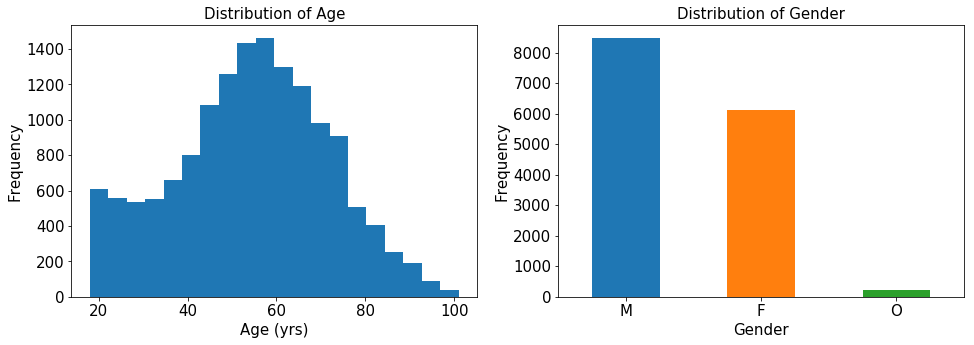

In [31]:
# View the distribution of the age and gender of our customer base
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
plt.hist(profile_clean[profile_clean.age <= 101].age, 20);
plt.xlabel("Age (yrs)", fontsize = '15')
#plt.xticks(rotation=90) 
plt.ylabel("Frequency", fontsize = '15')
plt.title("Distribution of Age", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')

plt.subplot(1,2,2)
ax = profile_clean['gender'].value_counts().plot(kind='bar', rot = 0)
ax.set_xlabel("Gender", fontsize = '15')
ax.set_ylabel("Frequency", fontsize = '15')
plt.title("Distribution of Gender", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.show();

> **There were more male customers than female customers in our profile data, with very few other gender.  The age of the customers is approaching a normal distribution but truncated on the left side with slightly more in the younger ages than the older ages**

In [32]:
# View the distribution (percentage) of gender by age groups
pd.crosstab(profile_clean['age_cat'], profile_clean['gender'], normalize='columns', margins=True)

gender,F,M,O,All
age_cat,,,,
0-30,0.077990,0.142504,0.084906,0.242159
31-40,0.085169,0.123645,0.122642,0.111029
41-50,0.146517,0.171735,0.169811,0.196290
51-60,0.256812,0.230198,0.297170,0.115008
61-70,0.216512,0.182579,0.160377,0.161282
71-80,0.125795,0.100424,0.108491,0.107723
81+,0.091206,0.048916,0.056604,0.066509


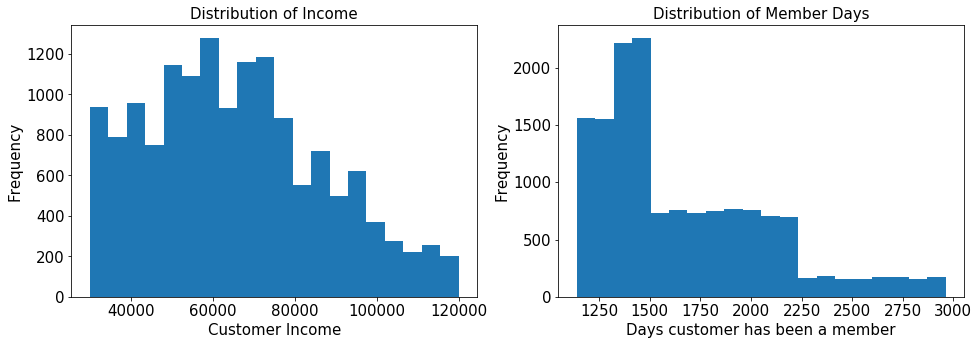

In [33]:
# View the distribution of the customer income and customer length of time
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
plt.hist(profile_clean[profile_clean.income > 0].income, 20);
plt.xlabel("Customer Income", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of Income", fontsize = '15')

plt.subplot(1,2,2)
plt.hist(profile_clean.days_member, 20);
plt.xlabel("Days customer has been a member", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of Member Days", fontsize = '15');

> **The income of the customers is truncated on the left with more customers in the lower income groups.  The length of time a customer has been a member is truncated on the left with fewer customers being long time members.**

In [34]:
# View the distribution (percentage) of gender by income groups
pd.crosstab(profile_clean['income_cat'], profile_clean['gender'], normalize='columns', margins=True)

gender,F,M,O,All
income_cat,,,,
0-45k,0.143743,0.252593,0.193396,0.145767
46-60k,0.202643,0.273927,0.292453,0.254772
61-75k,0.244738,0.263083,0.212264,0.244722
76-90k,0.192201,0.110325,0.221698,0.147993
91-120k,0.216675,0.100071,0.080189,0.206745


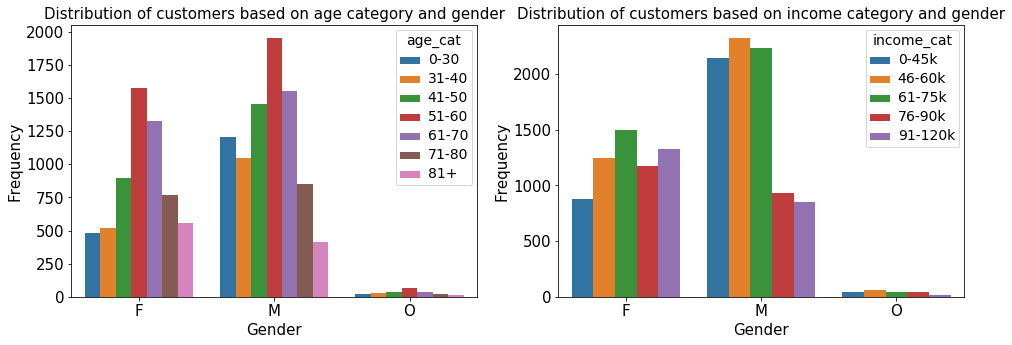

In [35]:
# View the income and age distributions by gender
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
#grp_temp1 = profile_clean.groupby(['gender', 'age_cat']).size()
#print(grp_temp1)
ax = sns.countplot(data=profile_clean, x='gender', hue='age_cat')
plt.setp(ax.get_legend().get_texts(), fontsize = '14')
plt.setp(ax.get_legend().get_title(), fontsize = '14')
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of customers based on age category and gender", fontsize = '15')

plt.subplot(1,2,2)
#grp_temp2 = profile_clean.groupby(['gender', 'income_cat']).size()
#print(grp_temp2)
ax =sns.countplot(data=profile_clean, x='gender', hue='income_cat')
plt.setp(ax.get_legend().get_texts(), fontsize = '14')
plt.setp(ax.get_legend().get_title(), fontsize = '14')
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of customers based on income category and gender", fontsize = '15');


In [36]:
grp_gender = profile_clean.groupby('gender')
grp_gender.age.mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

In [37]:
grp_gender.income.mean()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

> **It appears that there are more females in the older age groups than males and that there are proportionally more males in the younger age groups.  Also the males seem to be in the lower income brackets compared to the females that are somewhat evenly distributed across the income groups.**

### Purchase Analysis (all transactions)

In [38]:
# Create a dataframe aggregated per customer
profile_trans = cust_tran_summary(transcript2, profile_clean)
profile_trans.sort_values(by=['customer_id']).head()

,age,became_member_on,gender,customer_id,income,female,male,other_gender,member_month,member_year,days_member,age_cat,income_cat,member_cat,purchase_total,purchase_ave,num_trxns,off_received,off_viewed,off_completed,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,info_received,info_viewed,total_reward,total_net_value
3279,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,4,2017,1600,31-40,61-75k,1501-2000,127.60,15.950000,8,5,4,3,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,9.0,118.60
3639,40,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,1,2018,1337,31-40,46-60k,0-1500,79.46,15.892000,5,5,5,3,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,13.0,66.46
2220,59,2016-03-04,F,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,3,2016,2013,51-60,76-90k,2001-2500,196.86,24.607500,8,5,3,3,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,14.0,182.86
7347,24,2016-11-11,F,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,1,0,0,11,2016,1761,0-30,46-60k,1501-2000,154.05,12.837500,12,4,4,3,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,13.0,141.05
8827,26,2017-06-21,F,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,6,2017,1539,0-30,61-75k,1501-2000,48.34,2.685556,18,5,4,3,0.0,0.0,0.0,3.0,2.0,3.0,2.0,2.0,9.0,39.34


In [39]:
profile_trans.shape

(14825, 30)

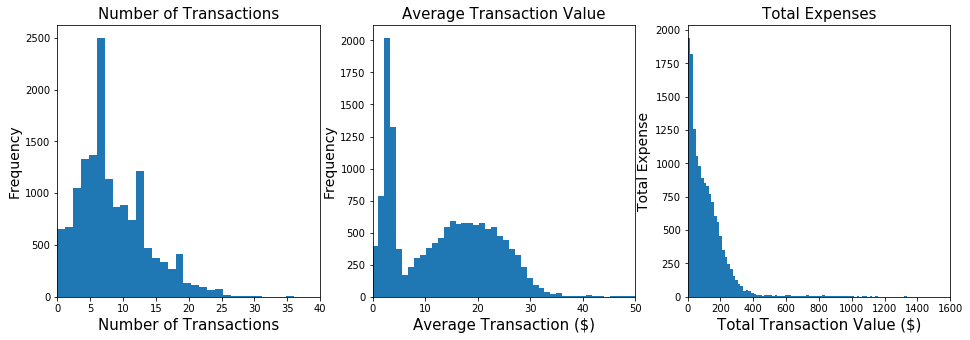

In [40]:
# View the purchase data by Customer
plt.figure(figsize = (16,5))

plt.subplot(1,3,1)
plt.hist(profile_trans.num_trxns, bins=30)
plt.xlabel("Number of Transactions", fontsize = '15')
plt.ylabel("Frequency", fontsize = '14')
plt.title("Number of Transactions", fontsize = '15')
ax = plt.gca()
ax.set_xlim(0,40)

plt.subplot(1,3,2)
plt.hist(profile_trans.purchase_ave, bins=400)
plt.xlabel("Average Transaction ($)", fontsize = '15')
plt.ylabel("Frequency", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15');
ax = plt.gca()
ax.set_xlim(0,50)

plt.subplot(1,3,3)
plt.hist(profile_trans.purchase_total, bins=100)
plt.xlabel("Total Transaction Value ($)", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Total Expenses", fontsize = '15')
ax = plt.gca()
ax.set_xlim(0,1600);

> **Both the number of transactions and the total transaction value per customer are skewed to the right, with more customers making fewer transactions and the total value the customer spent is in the lower range.  There appears to be a bimodal distribution for the average transaction made by the customers.  It seems a lot of customers buy small purchases like a cup of coffee more often.**

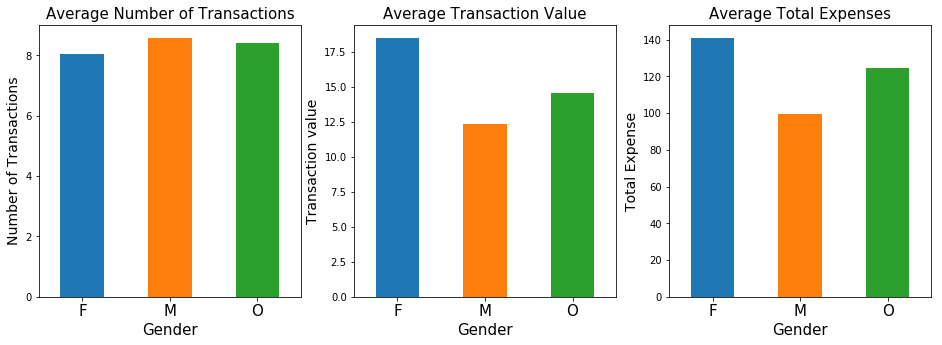

In [41]:
# View the transaction summary by Gender
plt.figure(figsize = (16,5))

grp_gender = profile_trans.groupby('gender')

plt.subplot(1,3,1)
grp_gender.num_trxns.mean().plot(kind='bar', rot = 0)
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '14')
plt.title("Average Number of Transactions", fontsize = '15')
plt.xticks(fontsize='15')

plt.subplot(1,3,2)
grp_gender.purchase_ave.mean().plot(kind='bar', rot = 0)
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15')
plt.xticks(fontsize='15')

plt.subplot(1,3,3)
grp_gender.purchase_total.mean().plot(kind='bar', rot = 0)
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Average Total Expenses", fontsize = '15')
plt.xticks(fontsize='15');

> **The average number of transactions per customer seem to be very similar for each gender type, but the females seem to spend more per transaction and also spend the most overall.**

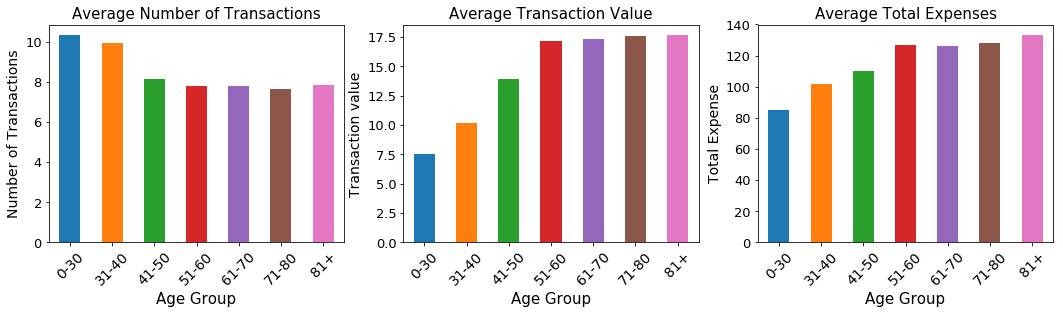

In [42]:
# View the transaction summary by Age Groups
plt.figure(figsize = (18,4))

grp_age = profile_trans.groupby('age_cat')

plt.subplot(1,3,1)
grp_age.num_trxns.mean().plot(kind='bar', rot = 45)
plt.xlabel("Age Group", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '14')
plt.title("Average Number of Transactions", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='13')

plt.subplot(1,3,2)
grp_age.purchase_ave.mean().plot(kind='bar', rot = 45)
plt.xlabel("Age Group", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='13')

plt.subplot(1,3,3)
grp_age.purchase_total.mean().plot(kind='bar', rot = 45)
plt.xlabel("Age Group", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Average Total Expenses", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='13');

(0, 200)

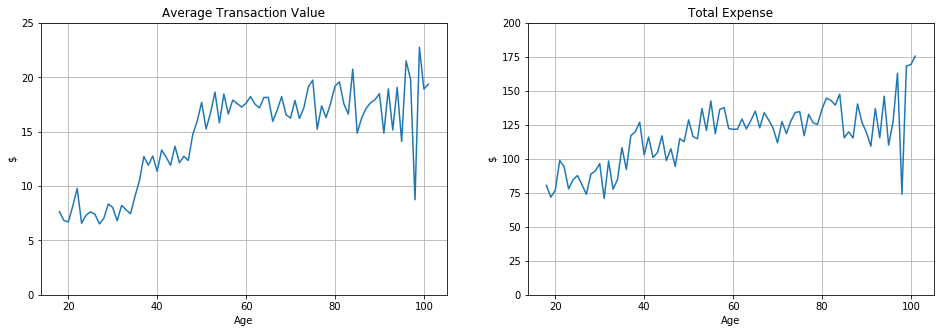

In [43]:
plt.figure(figsize=(16,5))

plt.subplot(121)
age_groupby = profile_trans.groupby('age')
age_transacts = age_groupby.num_trxns.sum()
age_expense = age_groupby.purchase_total.sum()
ax = age_groupby.purchase_ave.mean().plot(kind='line');
plt.title('Average Transaction Value');
ax.set_ylim(0, 25)
plt.grid(True)
plt.xlabel('Age')
plt.ylabel('$')


plt.subplot(122)
ax = age_groupby.purchase_total.mean().plot(kind='line');
plt.title('Total Expense');
plt.grid(True);
plt.xlabel('')
plt.xlabel('Age')
plt.ylabel('$')
ax.set_ylim(0, 200)

> **The younger age groups seem to make more purchases than the older age groups, yet the older age groups spend more per transaction and more overall. The average transaction value and total expenses increase as age increases as expected.**

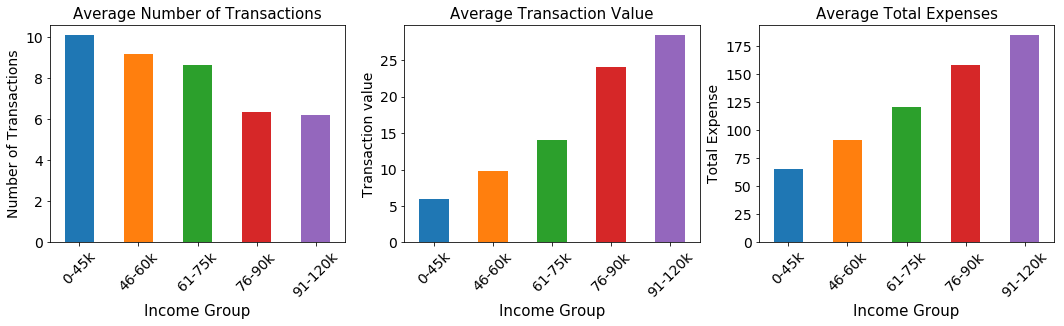

In [44]:
# View the transaction summary by Income Groups
plt.figure(figsize = (18,4))

grp_income = profile_trans.groupby('income_cat')

plt.subplot(1,3,1)
grp_income.num_trxns.mean().plot(kind='bar', rot = 45)
plt.xlabel("Income Group", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '14')
plt.title("Average Number of Transactions", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')

plt.subplot(1,3,2)
grp_income.purchase_ave.mean().plot(kind='bar', rot = 45)
plt.xlabel("Income Group", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')

plt.subplot(1,3,3)
grp_income.purchase_total.mean().plot(kind='bar', rot = 45)
plt.xlabel("Income Group", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Average Total Expenses", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14');

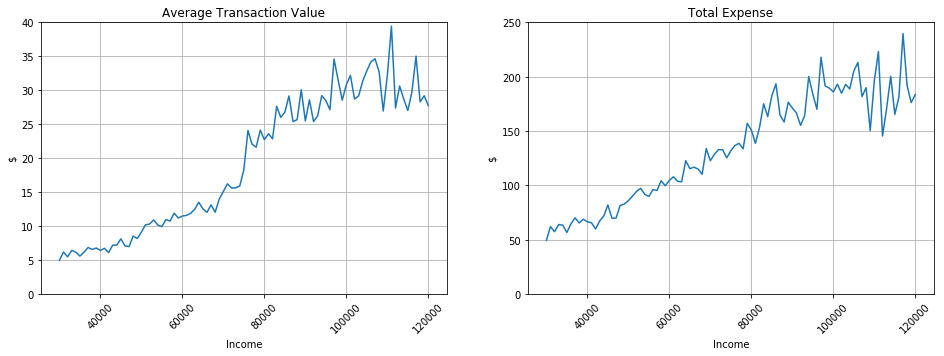

In [45]:
plt.figure(figsize=(16,5))

plt.subplot(121)
income_groupby = profile_trans.groupby('income')
income_transacts = income_groupby.num_trxns.sum()
income_expense = income_groupby.purchase_total.sum()
ax = (income_expense / income_transacts).plot(kind='line', rot=45);
plt.title('Average Transaction Value');
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 40)

plt.subplot(122)
ax = income_groupby.purchase_total.mean().plot(kind='line', rot=45);
plt.title('Total Expense');
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 250);

> **The lower income groups seem to make more purchases than the higher income groups, yet the higher income groups spend more per transaction and more overall which makes sense.  The average transaction value and total expenses increases as income does as expected.**

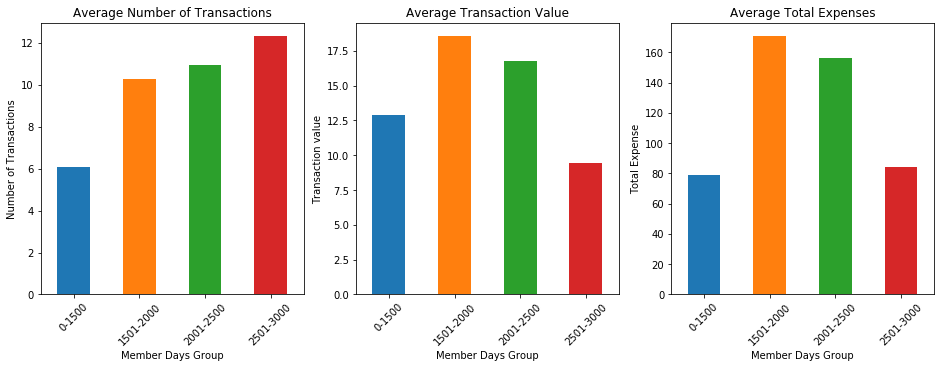

In [46]:
# View the transaction summary by Length of time customers were members
plt.figure(figsize = (16,5))

grp_member = profile_trans.groupby('member_cat')

plt.subplot(1,3,1)
grp_member.num_trxns.mean().plot(kind='bar', rot = 45)
plt.xlabel("Member Days Group")
plt.ylabel("Number of Transactions")
plt.title("Average Number of Transactions")

plt.subplot(1,3,2)
grp_member.purchase_ave.mean().plot(kind='bar', rot = 45)
plt.xlabel("Member Days Group")
plt.ylabel("Transaction value")
plt.title("Average Transaction Value")

plt.subplot(1,3,3)
grp_member.purchase_total.mean().plot(kind='bar', rot = 45)
plt.xlabel("Member Days Group")
plt.ylabel("Total Expense")
plt.title("Average Total Expenses");

> **The customers who have been members longer seem to make more purchases, but yet they spend the least per purchase and overall. This makes me assume the customers  who have been members longer are actually the younger and the lower income customers.** 

#### Correlations

In [47]:
# Calculate the correlation between demographics and offer data
profile_trans.corr()

,age,income,female,male,other_gender,member_month,member_year,days_member,purchase_total,purchase_ave,num_trxns,off_received,off_viewed,off_completed,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,info_received,info_viewed,total_reward,total_net_value
age,1.000000,0.306703,0.152200,-0.151504,0.000051,0.007717,-0.013537,0.012300,0.105787,0.192838,-0.155885,-0.005827,0.037627,0.114036,-0.005625,-0.001225,0.093131,-0.007583,0.039864,0.072947,0.009803,0.012061,0.116247,0.100900
income,0.306703,1.000000,0.229396,-0.225496,-0.011808,0.018851,-0.029325,0.025769,0.315033,0.474617,-0.266050,-0.006450,0.052653,0.257836,0.001454,0.001496,0.214025,-0.006348,0.060590,0.161574,-0.001578,0.006025,0.268321,0.306231
female,0.152200,0.229396,1.000000,-0.971083,-0.101119,0.032854,0.009715,-0.018673,0.154334,0.181997,-0.049285,-0.004724,0.018321,0.178685,0.000489,0.004113,0.152357,-0.009761,0.013531,0.108056,0.006175,0.007248,0.183264,0.146193
male,-0.151504,-0.225496,-0.971083,1.000000,-0.139322,-0.032253,-0.012119,0.021020,-0.155239,-0.180523,0.048835,0.009139,-0.024571,-0.181046,0.002626,-0.004073,-0.155056,0.011441,-0.017878,-0.108817,-0.006894,-0.012067,-0.185603,-0.146956
other_gender,0.000051,-0.011808,-0.101119,-0.139322,1.000000,-0.001867,0.010206,-0.010141,0.006761,-0.002617,0.000920,-0.018491,0.026397,0.013303,-0.012971,-0.000087,0.014201,-0.007190,0.018378,0.005268,0.003120,0.020224,0.013300,0.006015
member_month,0.007717,0.018851,0.032854,-0.032253,-0.001867,1.000000,-0.290296,0.049545,0.020100,0.017551,0.014545,-0.004100,-0.004038,0.027026,-0.001657,-0.004744,0.018726,-0.006725,-0.005972,0.020538,0.005758,0.007690,0.023716,0.019051
member_year,-0.013537,-0.029325,0.009715,-0.012119,0.010206,-0.290296,1.000000,-0.969935,-0.164071,-0.038676,-0.411360,0.006452,-0.016899,-0.222521,-0.004106,-0.009956,-0.133923,0.010155,-0.000824,-0.188785,0.000049,-0.013786,-0.171624,-0.157131
days_member,0.012300,0.025769,-0.018673,0.021020,-0.010141,0.049545,-0.969935,1.000000,0.166242,0.036015,0.425779,-0.005754,0.018714,0.225514,0.004673,0.011542,0.135038,-0.008989,0.002413,0.191991,-0.001420,0.012548,0.173134,0.159266
purchase_total,0.105787,0.315033,0.154334,-0.155239,0.006761,0.020100,-0.164071,0.166242,1.000000,0.761514,0.347459,0.090215,0.203629,0.537203,0.050053,0.087199,0.405513,0.052735,0.149482,0.375901,-0.021134,0.024597,0.501371,0.997953
purchase_ave,0.192838,0.474617,0.181997,-0.180523,-0.002617,0.017551,-0.038676,0.036015,0.761514,1.000000,-0.089248,0.001501,0.096033,0.327688,0.003593,0.020870,0.262389,-0.007480,0.074119,0.214693,0.006915,0.034666,0.326896,0.764013


> **It appears that age, females, males and income all have a somewhat moderate correlation with transaction values and total transactions.  The two reward offers (bogo and discount) being completed have a moderate correlation as well to the purchases made.**  

### Offer Analysis

In [48]:
# Apply the cust_offerfunction to create a dataframe for each customer/offer/transaction combination
cust_offer_details = cust_offer(starbucks_data, profile_clean, portfolio_clean)
cust_offer_details.head(10).sort_values(by='customer_id')

,age,age_cat,amount,became_member_on,bogo,bogo1,bogo2,bogo3,bogo4,ch__email,ch__mobile,ch__social,ch__web,customer_id,days_member,difficulty,discount,discount1,discount2,discount3,discount4,duration,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,female,gender,income,income_cat,info1,info2,informational,male,member_cat,member_month,member_year,offer_id,offer_type,other_gender,reward,reward_received,time_completed,time_received,time_trxn,time_viewed,viewed_prior,offer_id_clean,responded_to_offer,net_value
0,33,31-40,8.57,2017-04-21,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0009655768c64bdeb2e877511632db8f,1600,5.0,0.0,0.0,0.0,0.0,0.0,5.0,1,1,1,1,0,M,72000.0,61-75k,0.0,0.0,0.0,1,1501-2000,4,2017,bogo4,bogo,0,5.0,5.0,414.0,408.0,414.0,456.0,0,None,0,3.57
211371,33,31-40,13.56,2017-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0009655768c64bdeb2e877511632db8f,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,M,72000.0,61-75k,NaN,NaN,NaN,1,1501-2000,4,2017,NaN,No offer,0,NaN,0.0,NaN,NaN,552.0,NaN,0,None,0,13.56
79398,33,31-40,22.16,2017-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0009655768c64bdeb2e877511632db8f,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,M,72000.0,61-75k,NaN,NaN,NaN,1,1501-2000,4,2017,NaN,No offer,0,NaN,0.0,NaN,NaN,228.0,NaN,0,None,0,22.16
261068,33,31-40,12.36,2017-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0009655768c64bdeb2e877511632db8f,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,M,72000.0,61-75k,NaN,NaN,NaN,1,1501-2000,4,2017,NaN,No offer,0,NaN,0.0,NaN,NaN,660.0,NaN,0,None,0,12.36
267726,33,31-40,28.16,2017-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0009655768c64bdeb2e877511632db8f,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,M,72000.0,61-75k,NaN,NaN,NaN,1,1501-2000,4,2017,NaN,No offer,0,NaN,0.0,NaN,NaN,690.0,NaN,0,None,0,28.16
268880,33,31-40,18.41,2017-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0009655768c64bdeb2e877511632db8f,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,M,72000.0,61-75k,NaN,NaN,NaN,1,1501-2000,4,2017,NaN,No offer,0,NaN,0.0,NaN,NaN,696.0,NaN,0,None,0,18.41
4,33,31-40,NaN,2017-04-21,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0009655768c64bdeb2e877511632db8f,1600,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,1,1,0,0,M,72000.0,61-75k,0.0,1.0,1.0,1,1501-2000,4,2017,info2,informational,0,0.0,0.0,NaN,168.0,NaN,192.0,1,info2,0,NaN
3,33,31-40,NaN,2017-04-21,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0009655768c64bdeb2e877511632db8f,1600,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1,1,0,0,M,72000.0,61-75k,1.0,0.0,1.0,1,1501-2000,4,2017,info1,informational,0,0.0,0.0,NaN,336.0,NaN,372.0,1,info1,0,NaN
2,33,31-40,14.11,2017-04-21,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0009655768c64bdeb2e877511632db8f,1600,10.0,1.0,0.0,0.0,0.0,1.0,10.0,1,1,1,1,0,M,72000.0,61-75k,0.0,0.0,0.0,1,1501-2000,4,2017,discount4,discount,0,2.0,2.0,528.0,504.0,528.0,540.0,0,None,0,12.11
1,33,31-40,10.27,2017-04-21,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0009655768c64bdeb2e877511632db8f,1600,10.0,1.0,0.0,0.0,1.0,0.0,7.0,1,1,0,1,0,M,72000.0,61-75k,0.0,0.0,0.0,1,1501-2000,4,2017,discount3,discount,0,2.0,2.0,576.0,576.0,576.0,NaN,0,None,0,8.27


#### Offer Received

In [49]:
#view the number of offers received by offer id
pd.crosstab(starbucks_data[starbucks_data.event_offer_received == 1].offer_id,starbucks_data[starbucks_data.event_offer_received == 1].offer_type)           

offer_type,bogo,discount,informational
offer_id,,,
bogo1,6593,0,0
bogo2,6685,0,0
bogo3,6683,0,0
bogo4,6576,0,0
discount1,0,6726,0
discount2,0,6655,0
discount3,0,6631,0
discount4,0,6652,0
info1,0,0,6657


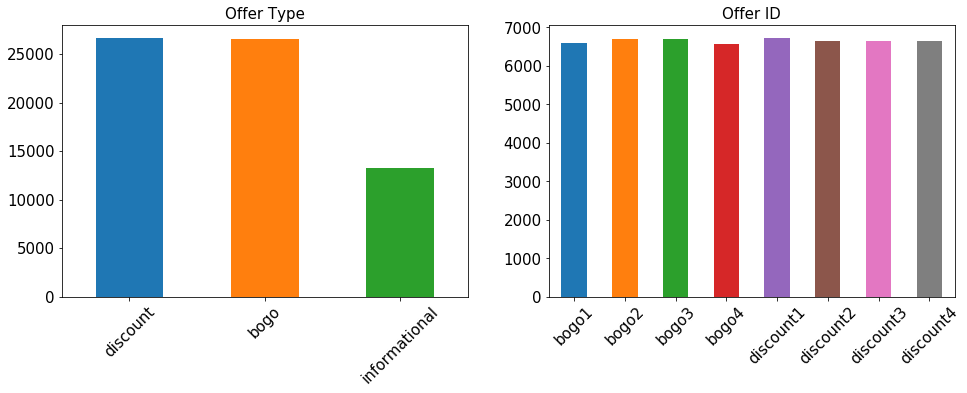

In [50]:
# View the offers sent out and received by customers
plt.subplot(1,2,1)
starbucks_data[starbucks_data.event_offer_received == 1].offer_type.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.title('Offer Type', fontsize = '15');
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')

plt.subplot(1,2,2)
offer_order = ['bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4']
starbucks_data[starbucks_data.event_offer_received == 1].offer_id.value_counts().loc[offer_order].plot(kind='bar', rot=45)
plt.title('Offer ID', fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15');

> **The 10 different offers recieved were distributed evenly amoungst the customers.  Since there were only 2 informational offers and 4 of both the discount and bogo offers, there are half the number of total informational offers**

In [51]:
# View the distribution of offers received out on the various channels
medium = starbucks_data[starbucks_data['event_offer_received'] == 1]
medium = medium[['ch__email', 'ch__mobile', 'ch__social', 'ch__web']]
medium.apply(pd.Series.value_counts)

,ch__email,ch__mobile,ch__social,ch__web
0.0,NaN,6726,26699,13326
1.0,66501.0,59775,39802,53175


> **The offers were sent out via email the most, and then the mobile app.  It was sent out via a social channel the least.**

#### Offers received

In [52]:
# View the distribution of offer types received from our cleaned data
cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_type.value_counts().sort_index()

bogo             22062
discount         22119
informational    11041
Name: offer_type, dtype: int64

In [53]:
# View the distribution of offers received by gender
pd.crosstab(cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_type,cust_offer_details[cust_offer_details['event_offer_received'] == 1].gender)

gender,F,M,O
offer_type,,,
bogo,9097,12662,303
discount,9110,12706,303
informational,4601,6277,163


In [54]:
# View the percentages of offers received by gender
pd.options.display.float_format = '{:.2f}'.format
pd.crosstab(cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_type,cust_offer_details[cust_offer_details['event_offer_received'] == 1].gender, normalize='columns', margins=True)

gender,F,M,O,All
offer_type,,,,
bogo,0.40,0.40,0.39,0.40
discount,0.40,0.40,0.39,0.40
informational,0.20,0.20,0.21,0.20


In [55]:
pd.crosstab(cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_id,cust_offer_details[cust_offer_details['event_offer_received'] == 1].gender, normalize='columns', margins=True)

gender,F,M,O,All
offer_id,,,,
bogo1,0.10,0.10,0.08,0.10
bogo2,0.10,0.10,0.11,0.10
bogo3,0.10,0.10,0.10,0.10
bogo4,0.10,0.10,0.10,0.10
discount1,0.10,0.10,0.10,0.10
discount2,0.10,0.10,0.11,0.10
discount3,0.10,0.10,0.09,0.10
discount4,0.10,0.10,0.09,0.10
info1,0.10,0.10,0.11,0.10


> **It appears that each specific offer type and each specific offer was distributed evenly amoung the gender types**

#### Offers viewed (for those who received an offer)

In [56]:
# View the distribution of offers viewed at any time for those who recieved an offer
df1 = cust_offer_details[cust_offer_details['event_offer_received'] == 1]
df1.event_offer_viewed.value_counts().sort_index()

0    12729
1    42493
Name: event_offer_viewed, dtype: int64

In [57]:
# View the distribution of those who viewed the offer after their purchase
cust_offer_details[cust_offer_details['viewed_prior'] == 0].event_offer_viewed.value_counts().sort_index()

0    101779
1      4272
Name: event_offer_viewed, dtype: int64

In [58]:
# View the distribution of offers viewed for those who recieved an offer by gender
pd.crosstab(df1.gender,df1.viewed_prior, normalize='index', margins=True)

viewed_prior,0,1
gender,,
F,0.31,0.69
M,0.31,0.69
O,0.23,0.77
All,0.31,0.69


> **Of the offers recieved by customers, 42493 offers were viewed, but 4272 of these were viewed after the offer was completed.  Customers probably wanted to view the offer they completed when they realized they just received a reward on their purchase.  I will consider these as not responding to the offer (event_offer_viewed2)**

In [59]:
# For those that received an offer, view the distribution of the specific offers that were viewed (excluding those 
# viewed after thier purchase)
pd.crosstab(df1.offer_id,df1.viewed_prior, normalize='index', margins=True)

viewed_prior,0,1
offer_id,,
bogo1,0.13,0.87
bogo2,0.54,0.46
bogo3,0.22,0.78
bogo4,0.15,0.85
discount1,0.69,0.31
discount2,0.14,0.86
discount3,0.54,0.46
discount4,0.12,0.88
info1,0.45,0.55


> **There were offers in each offer type that were viewed the most, not making one specific offer stand out as being viewed the most, although 'info2' was viewed 90% of the time**

In [60]:
# For those that received an offer, view the distribution of the specific offer types that were viewed (excluding 
# those viewed after thier purchase)
pd.crosstab(df1.offer_type,df1.viewed_prior, margins=True)

viewed_prior,0,1,All
offer_type,,,
bogo,5716,16346,22062
discount,8224,13895,22119
informational,3061,7980,11041
All,17001,38221,55222


In [61]:
# View percentages
pd.crosstab(df1['offer_type'], df1['viewed_prior'], normalize='index', margins=True)

viewed_prior,0,1
offer_type,,
bogo,0.26,0.74
discount,0.37,0.63
informational,0.28,0.72
All,0.31,0.69


> **For each offer type sent out, they were each proportionally viewed about the same amount, with the bogo offer viewed slightly more**

#### Offers completed

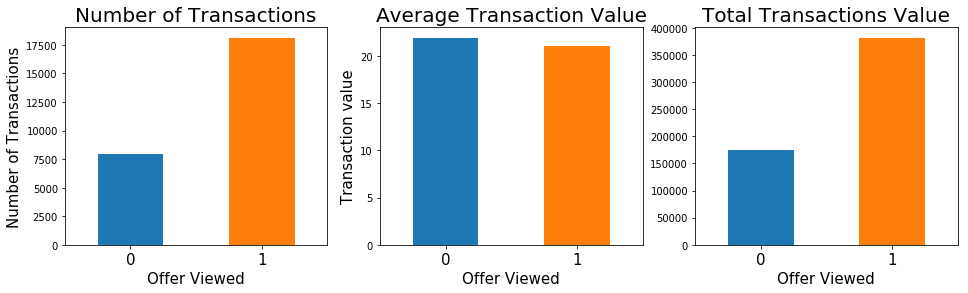

In [62]:
# View the transaction summary for the offers that were completed by those viewed (prior to completing) and not viewed 
plt.figure(figsize = (16,4))

df5 = cust_offer_details[cust_offer_details['event_offer_completed'] == 1]
grp_compl = df5.groupby('viewed_prior')

plt.subplot(1,3,1)
grp_compl.amount.count().plot(kind='bar', rot = 0)
plt.xlabel("Offer Viewed", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '15')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Number of Transactions", fontsize = '20')

plt.subplot(1,3,2)
grp_compl.amount.mean().plot(kind='bar', rot = 0)
plt.xlabel("Offer Viewed", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Average Transaction Value", fontsize = '20');

plt.subplot(1,3,3)
grp_compl.amount.sum().plot(kind='bar', rot = 0)
plt.xlabel("Offer Viewed", fontsize = '15')
#plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Total Transactions Value", fontsize = '20');

> **It clearly shows that viewing the offer increases the number of offers completed and the total transaction value, but there doesn't seem to be much difference between the average transaction.**

#### Offers responded to (received, viewed and completed in this order)

In [63]:
# View the total number of purchases in the dataset
cust_offer_details.event_transaction.value_counts().sort_index()

0     26304
1    117968
Name: event_transaction, dtype: int64

In [64]:
# View the number of completed reward offers in the dataset (regardless if they viewed their offer or not)
df2 = cust_offer_details[(cust_offer_details['offer_type'] == 'bogo') | (cust_offer_details['offer_type'] == 'discount')]
df2.event_offer_completed.value_counts().sort_index()

0    16239
1    27942
Name: event_offer_completed, dtype: int64

In [65]:
# For those who recieved a reward offer (bogo or discount), view the distribution of the offers completed for those who 
# viewed prior to their purchase versus those who did not view the offer (or post completion)
pd.crosstab(df2.viewed_prior,df2.event_offer_completed, margins=True)

event_offer_completed,0,1,All
viewed_prior,,,
0,5311,8629,13940
1,10928,19313,30241
All,16239,27942,44181


In [66]:
# View the percentages
pd.crosstab(df2['viewed_prior'], df2['event_offer_completed'], normalize='columns', margins=True)

event_offer_completed,0,1,All
viewed_prior,,,
0,0.33,0.31,0.32
1,0.67,0.69,0.68


> **For those that received a reward offer (bogo or discount), it appears that viewing the offer prior to completing the offer increases the chance the customer will complete the offer (69% vs 31%).**  

In [67]:
# View the distribution of events completed by offer type for those who viewed their offer prior to completing (those who 
# did not view the offer or did not view the offer prior to the purchase are considered 'no offer')
df3 = cust_offer_details[(cust_offer_details['viewed_prior'] == 1) & (cust_offer_details['offer_type'] != None)]
pd.crosstab(df3.offer_type,df3.event_offer_completed, margins=True)

event_offer_completed,0,1,All
offer_type,,,
bogo,7175,9171,16346
discount,3753,10142,13895
informational,7980,0,7980
All,18908,19313,38221


In [68]:
# View the percentages
pd.crosstab(df3['offer_type'], df3['event_offer_completed'], normalize='index', margins=True)

event_offer_completed,0,1
offer_type,,
bogo,0.44,0.56
discount,0.27,0.73
informational,1.00,0.00
All,0.49,0.51


In [69]:
# View the percentages
pd.crosstab(df3['offer_id'], df3['event_offer_completed'], normalize='index', margins=True)

event_offer_completed,0,1
offer_id,,
bogo1,0.52,0.48
bogo2,0.27,0.73
bogo3,0.50,0.50
bogo4,0.39,0.61
discount1,0.31,0.69
discount2,0.27,0.73
discount3,0.28,0.72
discount4,0.25,0.75
info1,1.00,0.00


> **Of the two types of reward offers sent out and received, the discount offers seems to influence customers to complete their offers more than the bogo offers did** 

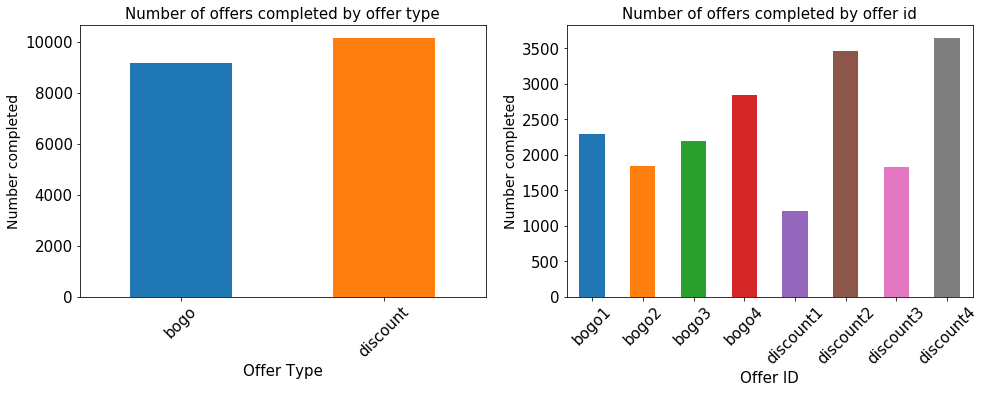

In [70]:
# View the offers completed by offer type and id
plt.figure(figsize = (16,5))

off_typ_comp = df3[df3.offer_type != 'informational'].groupby('offer_type')

plt.subplot(1,2,1)
off_typ_comp.event_offer_completed.sum().plot(kind='bar', rot = 45)
plt.xlabel("Offer Type", fontsize = '15')
plt.ylabel("Number completed", fontsize = '14')
plt.title("Number of offers completed by offer type", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')

off_id_comp = df3[df3.offer_type != 'informational'].groupby('offer_id')

plt.subplot(1,2,2)
off_id_comp.event_offer_completed.sum().plot(kind='bar', rot = 45)
plt.xlabel("Offer ID", fontsize = '15')
plt.ylabel("Number completed", fontsize = '14')
plt.title("Number of offers completed by offer id", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15');

#### Transaction summary for those who responsed to an offer

In [71]:
#View the number of transactions (purchases) per reward offer responded to (recieved, viewed and completed)
offer = cust_offer_details[cust_offer_details['responded_to_offer'] == 1]
offer.groupby('responded_to_offer')['amount'].count()

responded_to_offer
1    18124
Name: amount, dtype: int64

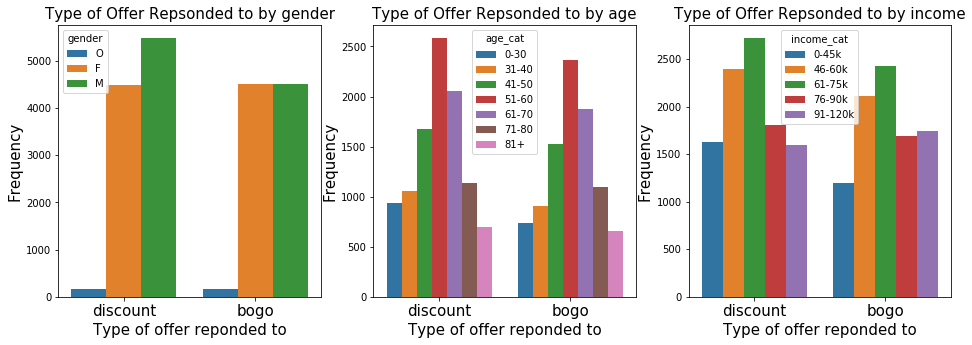

In [72]:
# View the transaction summary by Gender and Offer repsonded to
plt.figure(figsize = (16,5))

plt.subplot(1,3,1)
sns.countplot(data=offer, x='offer_type', hue='gender');
plt.xlabel("Type of offer reponded to", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.xticks(fontsize='15')
plt.title("Type of Offer Repsonded to by gender", fontsize = '15')

plt.subplot(1,3,2)
sns.countplot(data=offer, x='offer_type', hue='age_cat');
plt.xlabel("Type of offer reponded to", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.xticks(fontsize='15')
plt.title("Type of Offer Repsonded to by age", fontsize = '15');

plt.subplot(1,3,3)
sns.countplot(data=offer, x='offer_type', hue='income_cat');
plt.xlabel("Type of offer reponded to", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.xticks(fontsize='15')
plt.title("Type of Offer Repsonded to by income", fontsize = '15');

> **More men seem to respond to the discount offer than females, but both genders respond to the bogo offers the same.  The age distribution seems to be similar for both the discount and bogo offers with slightly more younger age groups reponding to the discount offer than the bogo offer.  The distribution across the income categories also seems similar for repsonse rate, although the lower income groups reponds more to the discount offers.** 

In [73]:
# View the average value of transactions for each offer repsonded to 
offer.groupby('offer_type')['amount'].mean()

offer_type
bogo       22.12
discount   20.10
Name: amount, dtype: float64

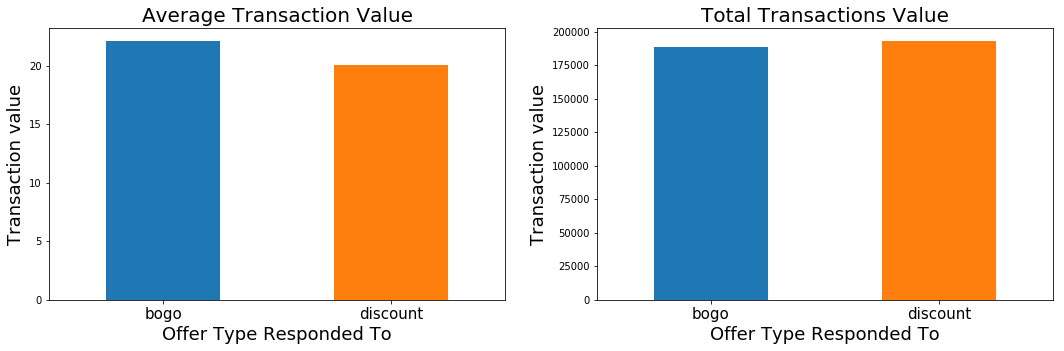

In [74]:
# View the transaction summary by Offer Type
plt.figure(figsize = (18,5))

grp_offer = offer.groupby('offer_type')

plt.subplot(1,2,1)
grp_offer.amount.mean().plot(kind='bar', rot = 0)
plt.xlabel("Offer Type Responded To", fontsize = '18')
plt.ylabel("Transaction value", fontsize = '18')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Average Transaction Value", fontsize = '20');

plt.subplot(1,2,2)
grp_offer.amount.sum().plot(kind='bar', rot = 0)
plt.xlabel("Offer Type Responded To", fontsize = '18')
plt.ylabel("Transaction value", fontsize = '18')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Total Transactions Value", fontsize = '20');

> **The number of purchases made for discount offers was slightly higher than for the bogo offers.  The average transaction value of the purchases was lower for the discount offers.  This makes sense as more customers can make more purchases if their purchases are less expensive.  The total amount of the transactions for each offer type are similar.**

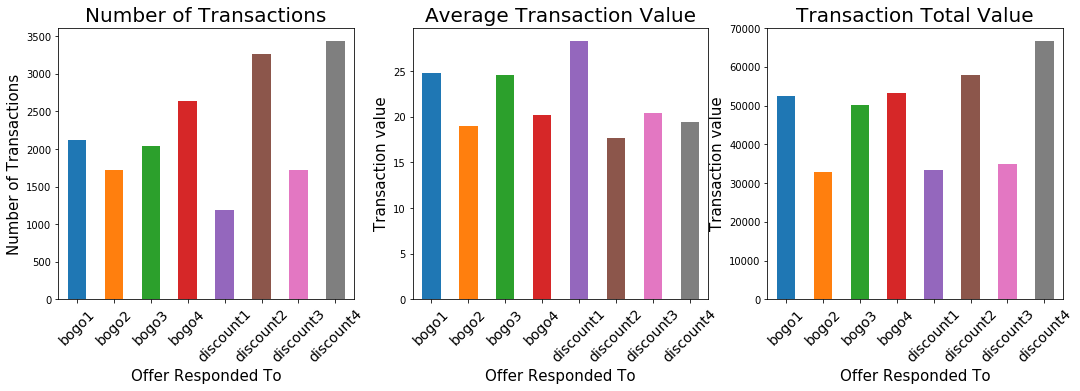

In [75]:
# View the transaction summary by Offer ID
plt.figure(figsize = (18,5))

grp_offer = offer.groupby(['offer_id'])

plt.subplot(1,3,1)
grp_offer.amount.count().plot(kind='bar', rot = 45)
plt.xlabel("Offer Responded To", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '15')
plt.xticks(fontsize='14')
plt.title("Number of Transactions", fontsize = '20')

plt.subplot(1,3,2)
grp_offer.amount.mean().plot(kind='bar', rot = 45)
plt.xlabel("Offer Responded To", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='14')
plt.title("Average Transaction Value", fontsize = '20');

plt.subplot(1,3,3)
grp_offer.amount.sum().plot(kind='bar', rot = 45)
plt.xlabel("Offer Responded To", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='14')
plt.title("Transaction Total Value", fontsize = '20');


> **It appears that the offer called discount4 (spend 10 dollars, save 2) had the most transactions as well as the highest total transaction value, where as the offer called discount1 (spend 20 dollars, save 5) had the highest average transaction value, but brought in one of the lowest revenue totals.** .  

In [76]:
# Create dataframe for correlations
# Keep only the necessary columns
corr_data = cust_offer_details[['customer_id', 'gender', 'event_offer_received', 'event_offer_viewed', 'event_offer_completed', 
                                'event_transaction', 'amount', 'offer_id', 'offer_type', 'duration', 'difficulty', 'reward_received', 
                                'ch__email', 'ch__mobile', 'ch__social', 'ch__web', 'responded_to_offer', 'age', 'income', 'days_member', 
                                'member_year', 'member_month', 'net_value']]
    
# Replace missing values with 0
corr_data = corr_data.fillna(0)

#Replace text values with numeric values
corr_data.replace({'gender' : { 'F' : 0, 'M' : 1, 'O' : 2 }}, inplace=True)
corr_data.replace({'offer_id' : {'0': 0, 'bogo1' : 1, 'bogo2' : 2, 'bogo3' : 3, 'bogo4' : 4, 'discount1' : 5, 'discount2' : 6,
                                 'discount3' : 7, 'discount4' : 8, 'info1' : 9, 'info1' : 10}}, inplace=True)
corr_data.replace({'offer_type' : {'No offer' : 0, 'bogo' : 1, 'discount' : 2, 'informational' : 3 }}, inplace=True)
      

              
corr_data.head()

,customer_id,gender,event_offer_received,event_offer_viewed,event_offer_completed,event_transaction,amount,offer_id,offer_type,duration,difficulty,reward_received,ch__email,ch__mobile,ch__social,ch__web,responded_to_offer,age,income,days_member,member_year,member_month,net_value
0,0009655768c64bdeb2e877511632db8f,1,1,1,1,1,8.57,4,1,5.00,5.00,5.00,1.00,1.00,1.00,1.00,0,33,72000.00,1600,2017,4,3.57
211371,0009655768c64bdeb2e877511632db8f,1,0,0,0,1,13.56,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,33,72000.00,1600,2017,4,13.56
79398,0009655768c64bdeb2e877511632db8f,1,0,0,0,1,22.16,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,33,72000.00,1600,2017,4,22.16
261068,0009655768c64bdeb2e877511632db8f,1,0,0,0,1,12.36,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,33,72000.00,1600,2017,4,12.36
267726,0009655768c64bdeb2e877511632db8f,1,0,0,0,1,28.16,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,33,72000.00,1600,2017,4,28.16


In [77]:
#Look at the correlations
corr_data.corr()

,gender,event_offer_received,event_offer_viewed,event_offer_completed,event_transaction,amount,offer_type,duration,difficulty,reward_received,ch__email,ch__mobile,ch__social,ch__web,responded_to_offer,age,income,days_member,member_year,member_month,net_value
gender,1.00,-0.03,-0.03,-0.08,-0.02,-0.08,-0.03,-0.03,-0.03,-0.08,-0.03,-0.03,-0.02,-0.03,-0.06,-0.13,-0.20,0.05,-0.04,-0.03,-0.07
event_offer_received,-0.03,1.00,0.82,0.62,-0.60,-0.03,0.88,0.92,0.74,0.52,1.00,0.92,0.69,0.84,0.50,0.07,0.13,-0.13,0.13,-0.00,-0.07
event_offer_viewed,-0.03,0.82,1.00,0.59,-0.41,-0.00,0.69,0.72,0.54,0.50,0.82,0.83,0.78,0.64,0.61,0.07,0.12,-0.10,0.10,-0.00,-0.04
event_offer_completed,-0.08,0.62,0.59,1.00,0.15,0.14,0.42,0.69,0.61,0.84,0.62,0.57,0.48,0.62,0.80,0.08,0.17,-0.01,0.01,0.01,0.08
event_transaction,-0.02,-0.60,-0.41,0.15,1.00,0.18,-0.64,-0.46,-0.32,0.12,-0.60,-0.55,-0.36,-0.44,0.12,-0.02,-0.02,0.17,-0.17,0.01,0.17
amount,-0.08,-0.03,-0.00,0.14,0.18,1.00,-0.05,0.00,0.03,0.13,-0.03,-0.03,-0.01,-0.01,0.11,0.08,0.20,0.00,-0.00,0.01,1.00
offer_type,-0.03,0.88,0.69,0.42,-0.64,-0.05,1.00,0.77,0.54,0.26,0.88,0.80,0.54,0.71,0.33,0.06,0.12,-0.12,0.12,-0.00,-0.07
duration,-0.03,0.92,0.72,0.69,-0.46,0.00,0.77,1.00,0.89,0.52,0.92,0.76,0.58,0.85,0.54,0.06,0.12,-0.12,0.12,-0.01,-0.04
difficulty,-0.03,0.74,0.54,0.61,-0.32,0.03,0.54,0.89,1.00,0.53,0.74,0.48,0.44,0.71,0.46,0.05,0.10,-0.10,0.10,-0.01,-0.01
reward_received,-0.08,0.52,0.50,0.84,0.12,0.13,0.26,0.52,0.53,1.00,0.52,0.48,0.47,0.42,0.67,0.07,0.16,-0.01,0.01,0.01,0.06


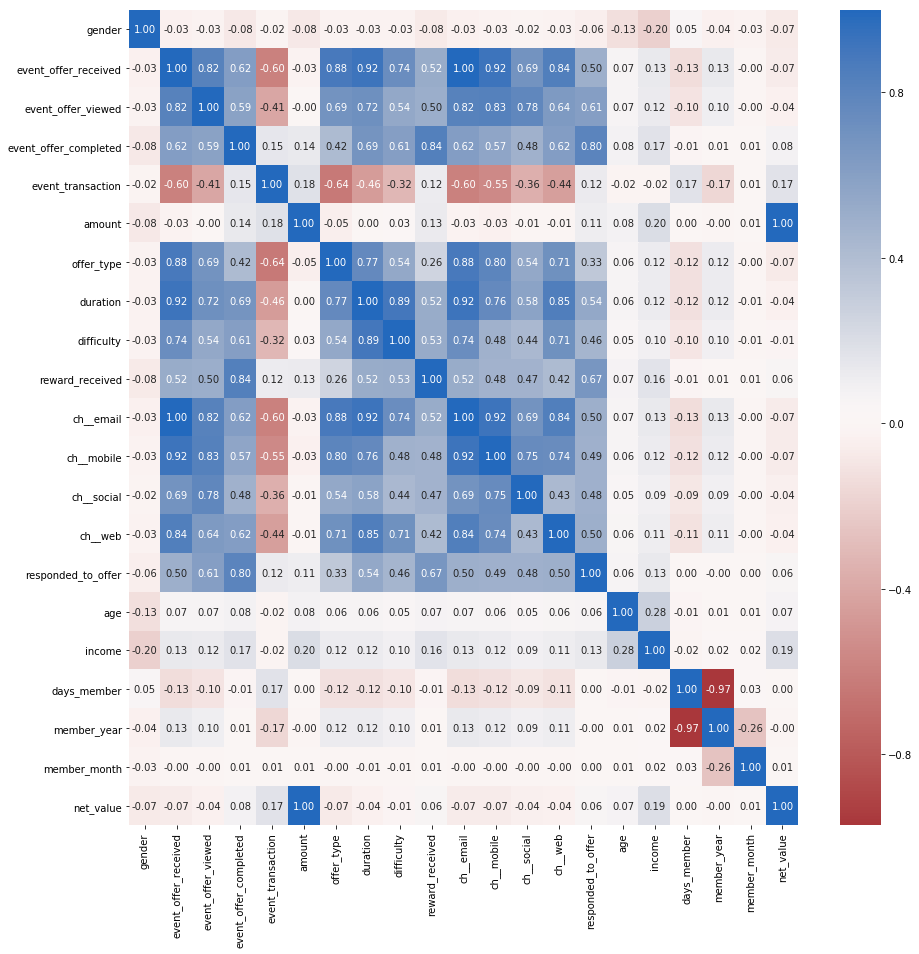

In [78]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_data.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r');

> **Looking at the correlations and heatmap we can see that 'responded_to_offer' is moderately correlated with, event received, viewed and completed. It is also moderately correlated with the duration, difficulty and reward recieved for each offer.** 

# Model Building

In [79]:
#Create clean dataframe for model building
model_data = modeling_data(cust_offer_details)

#Remove original columns that have been categorized as well as customer_id since we will not have this information 
#for new customers
model_data.drop(['customer_id', 'age', 'income', 'days_member'], axis=1, inplace = True)
model_data.head()

,gender,event_offer_received,event_offer_viewed,event_offer_completed,event_transaction,amount,offer_id,offer_type,duration,difficulty,reward_received,ch__email,ch__mobile,ch__social,ch__web,responded_to_offer,member_year,member_month,net_value,age_cat,income_cat,member_cat
0,1,1,1,1,1,8.57,4,1,5.00,5.00,5.00,1.00,1.00,1.00,1.00,0,2017,4,3.57,4,8,3
211371,1,0,0,0,1,13.56,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,2017,4,13.56,4,8,3
79398,1,0,0,0,1,22.16,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,2017,4,22.16,4,8,3
261068,1,0,0,0,1,12.36,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,2017,4,12.36,4,8,3
267726,1,0,0,0,1,28.16,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,2017,4,28.16,4,8,3


In [80]:
model_data.offer_id.unique()

array([ 4,  0, 10,  9,  8,  7,  5,  6,  2,  1,  3])

In [81]:
model_data.shape

(144272, 22)

In [82]:
model_data.describe()

,gender,event_offer_received,event_offer_viewed,event_offer_completed,event_transaction,amount,offer_id,offer_type,duration,difficulty,reward_received,ch__email,ch__mobile,ch__social,ch__web,responded_to_offer,member_year,member_month,net_value
count,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00,144272.00
mean,0.62,0.38,0.29,0.19,0.82,11.54,2.10,0.69,2.49,2.95,0.96,0.38,0.34,0.23,0.31,0.13,2016.42,6.71,10.65
std,0.51,0.49,0.46,0.40,0.39,29.88,3.21,0.99,3.45,5.08,2.34,0.49,0.48,0.42,0.46,0.34,1.25,3.50,29.64
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,1.00,-9.92
25%,0.00,0.00,0.00,0.00,1.00,1.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2016.00,4.00,1.05
50%,1.00,0.00,0.00,0.00,1.00,7.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2017.00,7.00,5.91
75%,1.00,1.00,1.00,0.00,1.00,17.25,4.00,1.00,5.00,5.00,0.00,1.00,1.00,0.00,1.00,0.00,2017.00,10.00,15.78
max,2.00,1.00,1.00,1.00,1.00,1062.28,10.00,3.00,10.00,20.00,10.00,1.00,1.00,1.00,1.00,1.00,2018.00,12.00,1062.28


In [83]:
model_data.responded_to_offer.value_counts()

0    124959
1     19313
Name: responded_to_offer, dtype: int64

**First I will try to fit a KNeighborsClassifier, which is one of the simplest machine learning algorithms**

In [84]:
# We split into the response and predictors and then fit the classifier models
X = model_data.drop('responded_to_offer', axis=1)
y = model_data['responded_to_offer']

In [85]:
X.shape

(144272, 21)

In [86]:
y.shape

(144272,)

In [87]:
# We split our dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
# define the classifier
classifier = KNeighborsClassifier(n_neighbors = 5)

In [89]:
classifier.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [90]:
# predictions
y_pred = classifier.predict(X_test)

In [91]:
print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

The accuracy is 0.9466752922693037 but the F-1 score is 0.8131174089068827


**Now lets try a different classifier to see if we can get better results**

In [92]:
# define the classifier
classifier = RandomForestClassifier()

In [93]:
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
# predictions
y_pred = classifier.predict(X_test)

In [95]:
print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

The accuracy is 0.9632179658980639 but the F-1 score is 0.8692080184028919


**Now lets try one more classifier to see if we can get better results**

In [96]:
# define the classifier
classifier = DecisionTreeClassifier(random_state=42, max_depth=4)

In [97]:
classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [98]:
# predictions
y_pred = classifier.predict(X_test)

In [99]:
print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

The accuracy is 0.9714661984196664 but the F-1 score is 0.9035080865692632


**This model gives us the best accuracy and F-1 score.  I'm not sure if we can improve the model by much, but I will try to change a few of the paramaters to see if it can improve it.**

In [100]:
# define the classifier, changing max_features to sqrt
classifier = DecisionTreeClassifier(random_state=42, max_depth=4, max_features='sqrt')

In [101]:
classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [102]:
# predictions
y_pred = classifier.predict(X_test)

In [103]:
print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

The accuracy is 0.949239868767617 but the F-1 score is 0.8296767191255136


**Changing the max_features parameter to 'sqrt' (max_features = sqrt(n_features))  doesn't make the model better, but rather decrease the accuracy and F1 score**

In [104]:
# define the classifier, changing max_features to sqrt
classifier = DecisionTreeClassifier(random_state=10, max_depth=4, class_weight='balanced', splitter='random')

In [105]:
classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='random')

In [106]:
# predictions
y_pred = classifier.predict(X_test)

In [107]:
print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

The accuracy is 0.9714661984196664 but the F-1 score is 0.9035080865692632


**Changing the class_weight parameter to 'balanced' and splitter to 'random' doesn't make the model accuracy or F1 score change**

## Conclusion

> **In the Exploratory Data Analysis, we saw that women tend to spend more money overall and per transaction then men do.  Also the higher age groups and income groups both tend to spend more per transaction and overall than the lower groups as expected.**  

> **Of the different reward offers received, the discount offers tend to be completed more than the bogo offers.  This may be a result of the discount offer allowing you to accumulate your purchases to the expenditure required over time and the bogo must be done in one purchase.  Also, of the discount offers completed, the one that was completed the most was the one that had the longest duration to complete and the second lowest amount of money to spend.  The second best offer completed the most was the discount offer with the lowest required amount to spend to complete.** 

> **For the model building, I chose to fit a few different classifiers for predicting whether a customer will respond to an offer.  The first classifier I tried to fit was the KNeighborClassifier which gave an accuracy of 0.9467 and an F-1 score is of 0.8131 which is pretty good.  Next I fit the RandomForestClassifier which gave me an accuracy of 0.9640 and F-1 score of 0.8721 which is an improvement on the KNeighborClassifier.  I decided to try to fit one more classifier to see if I could get better results.  With a DecisionTreeClassifier I was able to get the best results with an accuracy of 0.9715 and an F-1 score of 0.9035.**

> **I tried to adjust a few parameters of the Decision Tree Classifier to see if I could improve the results, but I made my model worse or the same with the ajustments.  So the original Decision Tree Classifier model was the best at predicting whether someone would respond to an offer.**